# Non-robust feature transfer for a new adversarial attack

## import dataset

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import mnist, cifar10
from keras.models import load_model
from keras.utils.np_utils import to_categorical
import numpy as np

from art import config
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import get_file
import tensorflow as tf


#import the dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 

#the input of the small CNN model is centered and reduced
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
red_center = False

x_train_red= (x_train-mean)/(std+1e-7)
x_test_red= (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
 



## Define the small CNN model

In [ ]:

weight_decay = 1e-4
small_CNN = Sequential()
small_CNN.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
small_CNN.add(Activation('elu'))
small_CNN.add(BatchNormalization())
small_CNN.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
small_CNN.add(Activation('elu'))
small_CNN.add(BatchNormalization())
small_CNN.add(MaxPooling2D(pool_size=(2,2)))
small_CNN.add(Dropout(0.2))
 
small_CNN.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
small_CNN.add(Activation('elu'))
small_CNN.add(BatchNormalization())
small_CNN.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
small_CNN.add(Activation('elu'))
small_CNN.add(BatchNormalization())
small_CNN.add(MaxPooling2D(pool_size=(2,2)))
small_CNN.add(Dropout(0.3))
 
small_CNN.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
small_CNN.add(Activation('elu'))
small_CNN.add(BatchNormalization())
small_CNN.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
small_CNN.add(Activation('elu'))
small_CNN.add(BatchNormalization())
small_CNN.add(MaxPooling2D(pool_size=(2,2)))
small_CNN.add(Dropout(0.4))
 
small_CNN.add(Flatten())
small_CNN.add(Dense(num_classes, activation='softmax'))
 
small_CNN.summary()
 


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

### Loading the pretrained weights of the small CNN

In [ ]:
!wget https://raw.githubusercontent.com/aVariengien/non-robust-feature-extractor/master/pretrained%20CIFAR10/model.h5
model.load_weights("model.h5")
opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

## Import additionnal models from [Sinn et al. (2019)](https://drive.google.com/uc?export=download&id=1XmUSqU7qCYigVqgEKvoT2p__Fy-Dq9Cx)

In [ ]:
path = get_file('cifar-10_ratio=1.h5',extract=False, path='dl_models',
                url='https://www.dropbox.com/s/7btc2sq7syf68at/cifar-10_ratio%3D1.h5?dl=1')


robust_model = load_model(path)
robust_model.summary()

In [ ]:
path = get_file('cifar-10_ratio=0.h5',extract=False, path='dl_models',
                url='https://www.dropbox.com/s/hbvua7ynhvara12/cifar-10_ratio%3D0.h5?dl=1')


natural_model = load_model(path)
natural_model.summary()


## Test the models

In [ ]:
#testing the small CNN
t1 = time.time()
scores = model.evaluate(x_test_nm, y_test, batch_size=64, verbose=1)
t2 = time.time()

print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
print("Test time ", t2-t1, "s")

7.442444801330566

Test result: 77.300 loss: 0.806


In [ ]:
#testing the robust model
t1 = time.time()
scores = robust_model.evaluate(x_test, y_test, batch_size=64, verbose=1)
t2 = time.time()
print("Test time ", t2-t1, "s")
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

8/8 - 2s - loss: 0.4980 - accuracy: 0.9340 - 2s/epoch - 304ms/step

Test result: 93.400 loss: 0.498


In [ ]:
#testing the natural model
t1 = time.time()
scores = natural_model.evaluate(x_test, y_test, batch_size=64, verbose=1)
t2 = time.time()
print("Test time ", t2-t1, "s")
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# define utils

In [ ]:
def process_output_img(x, smallCNN=False):
  """Convert the output of the network in an image with pixels
  values in [0,1]"""
  if smallCNN:
    return (x*std+mean)/255.
  else:
    return x/255

def plot_and_saveimg(savepath,nrfXT,N=10, smallCNN=False):
  """Plot and save N examples images"""

  #random sample
  d = np.random.randint(0,10000)
  img1 = d1[d:d+N]
  img2 = d2[d:d+N]

  y_pred = nrfXT([img1, img2])
  pred_labels = get_cifar_classes(y_pred)

  pre_classifier_img = nrfXT.combinator.predict(np.concatenate([ img1, img2], axis=-1))

  cover_img_pred = get_cifar_classes(nrfXT.classifier.predict(img2))
  hidden_img_pred = get_cifar_classes(nrfXT.classifier.predict(img1))

  f, axarr = plt.subplots(N,7, figsize=(25,N*4))

  for i in range(N):
    if i == 0:
      axarr[i][0].set_title("Cover image")
      axarr[i][1].set_title("Cover image prediction")
      axarr[i][2].set_title("Hidden image")
      axarr[i][3].set_title("Hidden image prediction")
      axarr[i][4].set_title("Image given to the classifier")
      axarr[i][5].set_title("Final Classification")

    axarr[i][0].imshow(process_output_img(img2[i]))
    axarr[i][1].text(0,0,cover_img_pred[i])
    axarr[i][1].axis("off")
    axarr[i][2].imshow(process_output_img(img1[i]))
    axarr[i][3].text(0,0,hidden_img_pred[i])
    axarr[i][3].axis("off")
    axarr[i][4].imshow(process_output_img(pre_classifier_img[i], smallCNN))

    axarr[i][5].text(0,0,pred_labels[i])
    axarr[i][5].axis("off")
  f.savefig(savepath)




In [ ]:
import random, string
#to generate random name for the experiments
def random_string(N=6):
  return "XP_"+''.join(random.choices(string.ascii_uppercase + string.digits, k=N))

In [ ]:
CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
def get_cifar_classes(y1):
  s = ""
  if len(y1.shape) == 1:
    y = np.expand_dims(y1, axis=0)
  else:
    y = y1
  class_descriptions = []
  for i in range(len(y)):
    s = ""

    classes = []
    for j in range(len(y[i])):
      classes.append((CLASSES[j], np.round(y[i][j], 3)))
    classes.sort(key = (lambda x: -x[1]) )

    for j in range(len(y[i])):
      s+= classes[j][0] + ": " + str(classes[j][1])+" " +"\n"*(j%2)
    s+= "\n"
    class_descriptions.append(s)
  return class_descriptions

## Define combinator

In [4]:



from keras.layers import Dropout

combi = Sequential()
combi.add(Conv2D(64, (5,5), padding='same',  input_shape=(32,32,6),  activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(64, (4,4), padding='same',  activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(3, (3,3), padding='same',  activation=None))
combi.summary()



NameError: ignored

## Define train and test set to train the combinator

In [ ]:
#we split in half the original CIFAR dataset to get unique cover and secret images
d2 = x_train[25000:] #cover
d1 = x_train[:25000] #secret

d2_test = x_test[5000:] #cover
d1_test = x_test[:5000] #secret

y1 = y_train[:25000] #we keep only the labels of the secret image
y1_test = y_test[:5000]

## Define NRFextractor

In [ ]:
#define a callback to log the experiments

import os

val_acc = []
train_acc = []

val_loss = []
train_loss = []

EPOCH = 0
XP_NAME = random_string()

avg_acc = 0
avg_dist = 0
class LogCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global EPOCH,avg_acc, avg_dist
        train_acc.append(logs["accuracy"])
        train_loss.append(logs["Raw mean L2 distance to image"])
        val_acc.append(logs["val_accuracy"])
        val_loss.append(logs["val_Raw mean L2 distance to image"])
        print(logs.keys())
        EPOCH = epoch+1
        avg_acc = 0
        avg_dist = 0
        if not(os.path.isdir("XP")):
          os.mkdir("XP")
        if not(os.path.isdir("XP/"+XP_NAME+"/")):
          os.mkdir("XP/"+XP_NAME+"/")
        plot_and_saveimg("XP/"+XP_NAME+"/"+XP_NAME+"_"+str(epoch)+".png", self.model )
    def on_batch_end(self, batch, logs=None):
      global avg_acc, avg_dist
      avg_acc+= logs["accuracy"]
      avg_dist+= logs["Raw mean L2 distance to image"]
      if batch%10 == 0:
        with open('log.txt', 'a') as log_file:
          log_file.write(XP_NAME+";"+str(EPOCH)+";"+str(batch)+";"+str(avg_dist/10)+";"+str(avg_acc/10)+"\n")
          #print(logs, batch)
        avg_acc = 0
        avg_dist = 0



def reset_logs():
  val_acc = []
  train_acc = []

  val_loss = []
  train_loss = []


In [ ]:

#manual plotting of the learning curves

def plot_learning_curves():
  f, p = plt.subplots(2,1, figsize=(15,10))
  p[0].plot(train_acc, label="Training accuracy")
  p[0].plot(val_acc, label="Validation accuracy")
  p[0].set_xlabel("epoch")
  p[0].legend()

  p[1].plot(train_loss, label="Training Raw mean L2 distance to image")
  p[1].plot(val_loss, label="Validation Raw mean L2 distance to image")
  p[1].set_xlabel("epoch")
  p[1].legend()

In [ ]:
#definition of the main model

class NRFextractor(keras.Model):
    def __init__(self, classifier, combinator,classif_w = 1.,dist_w=1., smallCNN=False **kwargs):
        super(NRFextractor, self).__init__(**kwargs)

        self.classifier = classifier #pretrained classifier
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.cla_loss_tracker = keras.metrics.Mean(name="classification loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distance to image loss")
        self.dist_tracker = keras.metrics.Mean(name="Raw mean L2 distance to image")

        self.acc_tracker = tf.keras.metrics.CategoricalAccuracy(name="accuracy")

        self.classif_w = classif_w
        self.dist_w = dist_w
        self.smallCNN = smallCNN

        self.combinator = combinator


        self.acc_history = []
        self.loss_history = []


        self.val_acc_history = []
        self.val_loss_history = []

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.acc_tracker,
            self.cla_loss_tracker,
            self.dist_loss_tracker,
            self.dist_tracker
        ]
    def call(self, data):
      i1, i2 = data

      imgs = tf.concat([i1, i2],axis=-1)
      img = self.combinator(imgs)

      out = self.classifier(img)
      return out

    def train_step(self, data):
        imgs, y1 = data
        i1, i2 = imgs

        with tf.GradientTape(persistent=False) as tape:

          imgs_c = tf.concat([i1, i2],axis=-1)
          img = self.combinator(imgs_c)
          out = self.classifier(img)
          cla_loss = tf.keras.losses.binary_crossentropy(out, y1)

          distance_to_cov_img = tf.reduce_sum( tf.square(i2-img ))

          loss = distance_to_cov_img*self.dist_w + self.classif_w * cla_loss


        grads_combi = tape.gradient(loss, self.combinator.weights)
        self.optimizer.apply_gradients(zip(grads_combi, self.combinator.weights))

        self.loss_tracker.update_state(loss)
        self.cla_loss_tracker.update_state(self.classif_w *cla_loss)
        self.dist_loss_tracker.update_state(distance_to_cov_img*self.dist_w)

        L2_norm = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square((process_output_img(i2, self.smallCNN)-process_output_img(img, , self.smallCNN))), axis=[0,1, 2])))
        self.dist_tracker.update_state(L2_norm)
        self.acc_tracker.update_state(out, y1)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        imgs, y1 = data
        i1, i2 = imgs
        imgs_c = tf.concat([i1, i2],axis=-1)
        img = self.combinator(imgs_c)

        out = self.classifier(img)
        cla_loss = tf.keras.losses.binary_crossentropy(out, y1)
        distance_to_cov_img = tf.reduce_sum( tf.square((i2-img) ))
        loss = distance_to_cov_img + self.classif_w * cla_loss

        self.loss_tracker.update_state(loss)
        self.cla_loss_tracker.update_state(loss)
        self.dist_loss_tracker.update_state(distance_to_cov_img*self.dist_w)
        L2_norm = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square((process_output_img(i2, self.smallCNN)-process_output_img(img, , self.smallCNN))), axis=[0,1, 2])))
        self.dist_tracker.update_state(L2_norm)
        self.acc_tracker.update_state(out, y1)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}



## Create and train the NRFextractor

In [ ]:
def makedir_if_not_here(p):
  if not(os.path.isdir(p)):
    os.mkdir(p)

In [ ]:
from keras.metrics import MeanSquaredError

EXPERIMENTS = [2e4,4e4,5e4, 6e4, 7e4, 8e4, 9e4, 11e4]

model_type = 'robust' #'smallCNN' 'natural'

classif_weights = 1e4
dist_weights = 3e-1


#define the combinator
combi = Sequential()
combi.add(Conv2D(64, (5,5), padding='same',  input_shape=(32,32,6),  activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(64, (4,4), padding='same',  activation="relu"))
combi.add(Dropout(0.1))
combi.add(Conv2D(3, (3,3), padding='same',  activation=None) )


#run the experiment

XP_NAME = random_string()+"-"+model_type+"-"+str(classif_weights).replace(".", "_")
EPOCH = 0

#create folders
checkpoint_filepath = 'checkpoints/'+XP_NAME+'/weights.{epoch:02d}-{val_accuracy:.4f}-{val_Raw mean L2 distance to image:.4f}.hdf5'
makedir_if_not_here("checkpoints")
makedir_if_not_here("checkpoints/"+XP_NAME+'/')

#define the corresponding classifier
use_smallCNN = False
if model_type == 'robust':
  classif_model = robust_model
elif model_type == 'natural':
  classif_model = natural_model
elif model_type == 'natural':
  classif_model = small_CNN
  use_smallCNN = True
else:
  classif_model = None #error !

#define callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=False,
    verbose=1)

#define main model
nrfXT = NRFextractor(classif_model, combi, classif_w = classif_weights,dist_w=dist_weights, smallCNN=use_smallCNN)


boundaries = [500,1500]
values = [0.001, 0.0005, 0.0001]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

loss_fn = keras.losses.SparseCategoricalCrossentropy()
nrfXT.compile(metrics=['accuracy', 'loss', 'classification loss', 'distance to image loss', 'Raw mean L2 distance to image'], 
              optimizer=opt_adam,
              loss=loss_fn)

nrfXT.fit([d1,d2], y1,batch_size=64, epochs=20, 
          validation_data=([d1_test, d2_test],y1_test), 
          verbose=1) 


# Evaluate the attack

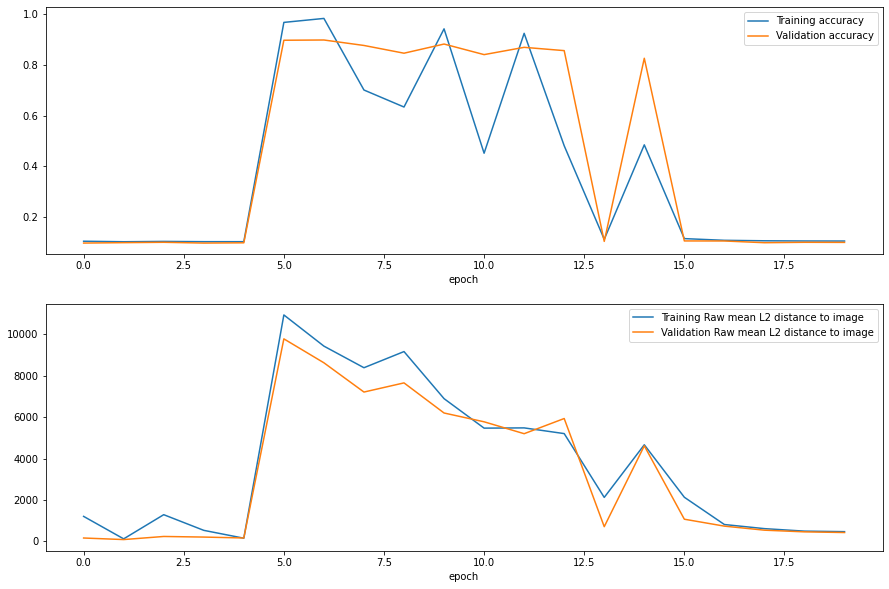

In [ ]:
plot_learning_curves()

## Confusion matrix

Secret labels


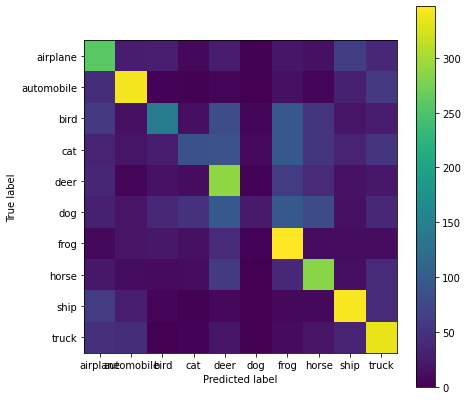

Cover labels


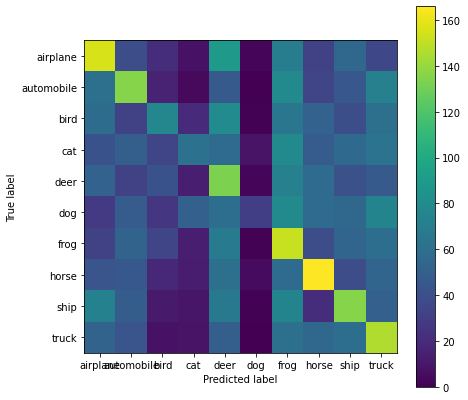

In [ ]:
y_pred = nrfXT.predict([d1_test, d2_test])

from sklearn.metrics import confusion_matrix

def plot_conf_mtx(y_pred, true_labels, title=""):
  matrix = confusion_matrix(true_labels.argmax(axis=1), y_pred.argmax(axis=1))
  fig, ax = plt.subplots(1,1, figsize=(7,7))

  img = ax.imshow(matrix,extent=[0,10,0,10])
  x_label_list = CLASSES
  ax.set_xticks([i+0.5 for i in range(10)])
  ax.set_xticklabels(CLASSES)
  ax.set_yticks([i+0.5 for i in range(10)])
  ax.set_yticklabels(CLASSES[::-1])
  ax.set_xlabel("Predicted label")
  ax.set_ylabel("True label")
  ax.set_title(title)
  fig.colorbar(img)

plot_conf_mtx(y_pred, y1_test, "Secret labels")
plt.show()


plot_conf_mtx(y_pred, y_test[5000:], "Cover labels")
plt.show()



## Visualize the container images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


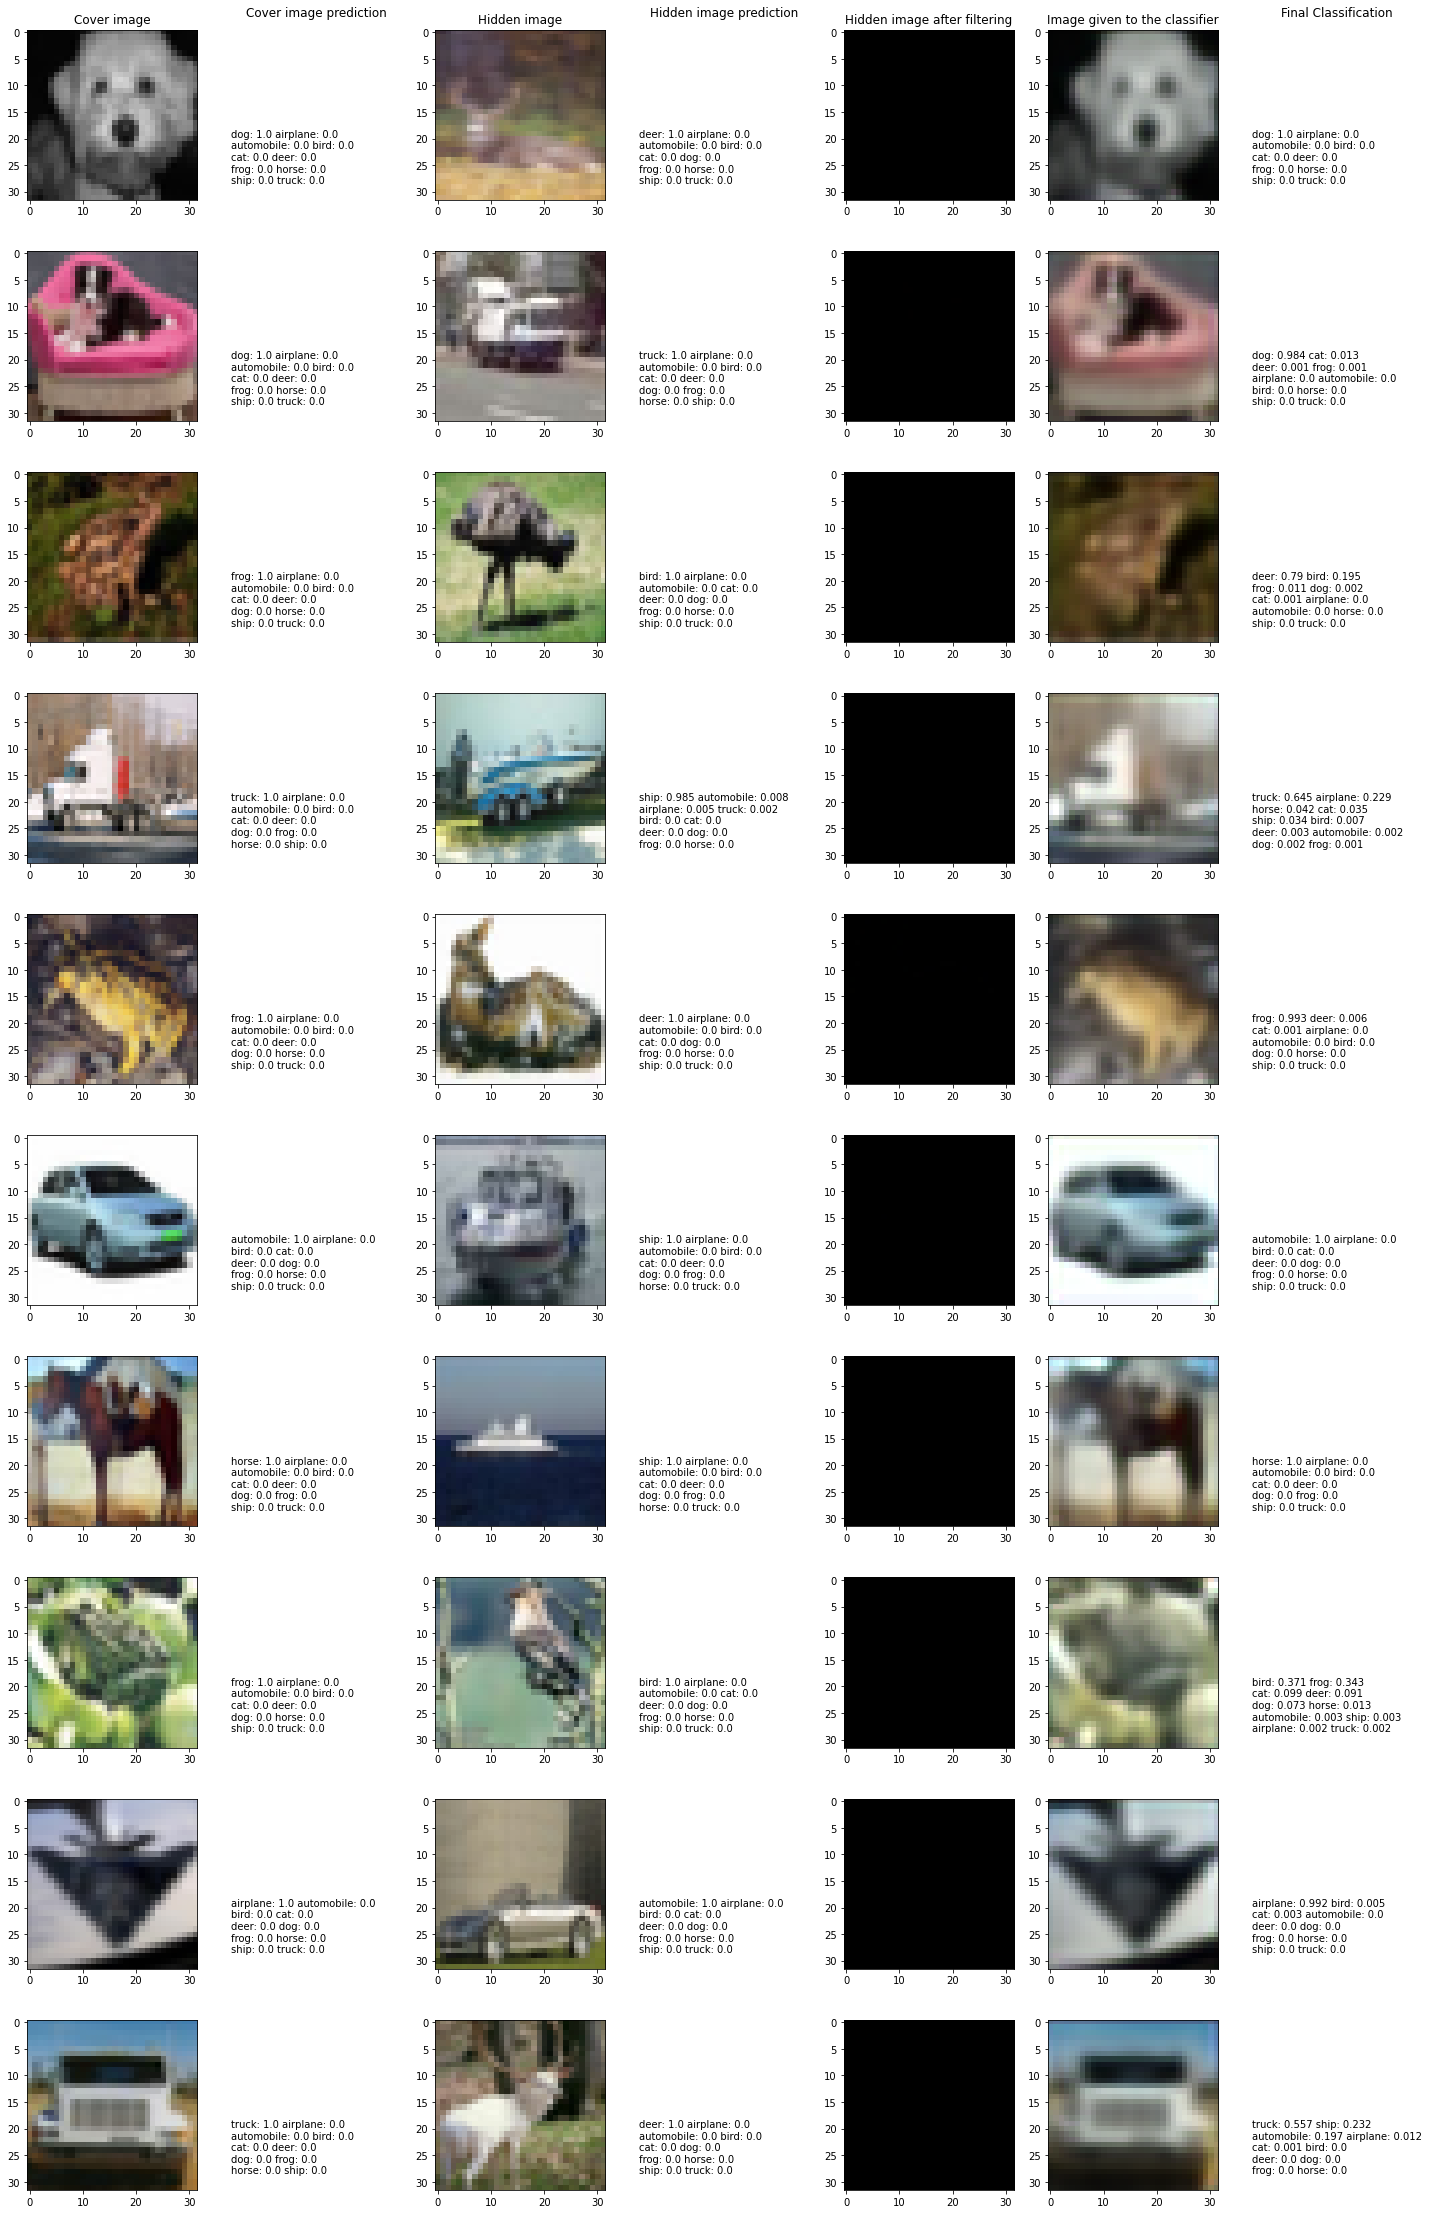

In [ ]:

plot_and_saveimg("attack.png", nrfXT, nrfXT.smallCNN)



## Decoder Experiments

In [ ]:
from keras.layers import Dropout

decoder = Sequential()
decoder.add(Conv2D(64, (5,5), padding='same',  input_shape=(32,32,3),  activation="relu"))
decoder.add(Dropout(0.1))
#combi.add(Conv2D(64, (5,5), padding='same',  input_shape=x_train.shape[1:],  activation="relu"))
decoder.add(Conv2D(64, (4,4), padding='same',  activation="relu"))
decoder.add(Conv2D(64, (4,4), padding='same',  activation="relu"))
decoder.add(Dropout(0.1))
decoder.add(Conv2D(3, (3,3), padding='same',  activation=None) )
#filter.add(layers.Conv2DTranspose(3, (5,5), padding='same', strides=1,  activation="sigmoid"))

decoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 dropout_30 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 dropout_31 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 3)         1731      
                                                                 
Total params: 137,795
Trainable params: 137,795
Non-t

In [ ]:
d1.shape

(25000, 32, 32, 3)

### Define train and test cover images

In [ ]:
filtered = nrfXT.filter(d1).numpy()
if nrfXT.sig_act_filter:
  filtered = 2*filtered-0.5
else:
  pass
  filtered = (filtered - np.min(filtered)) / (np.max(filtered) - np.min(filtered) + 1e-8)

filtered_test = nrfXT.filter(d1_test).numpy()
if nrfXT.sig_act_filter:
  filtered_test = 2*filtered_test-0.5
else:
  pass
  filtered_test = (filtered_test - np.min(filtered_test)) / (np.max(filtered_test) - np.min(filtered_test) + 1e-8)




x_train_after_combi = nrfXT.combinator.predict(np.concatenate([ filtered, d1], axis=-1))/255
x_test_after_combi = nrfXT.combinator.predict(np.concatenate([ filtered_test, d1_test], axis=-1))/255



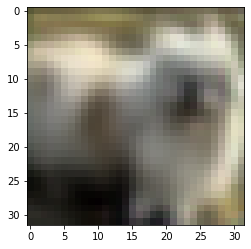

In [ ]:
plt.imshow(x_train_after_combi[40]) #d1


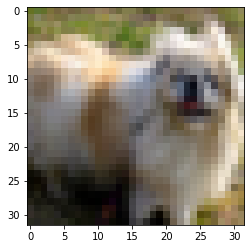

In [ ]:
plt.imshow(filtered[40])

In [ ]:
boundaries = [100,500, 1500]
values = [0.01, 0.005,0.001, 0.0005]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
loss_fn = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

decoder.compile(loss=loss_fn, optimizer=opt_adam)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        9664      
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 3)         1731      
                                                                 
Total params: 76,995
Trainable params: 76,995
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder.fit(x_train_after_combi, d2/255,batch_size=128, epochs=40, validation_data=(x_test_after_combi, d2_test/255), verbose=1)

Epoch 1/40
196/196 [==============================] - 19s 99ms/step - loss: 0.0633 - val_loss: 0.0632
Epoch 2/40
196/196 [==============================] - 19s 97ms/step - loss: 0.0630 - val_loss: 0.0630
Epoch 3/40
196/196 [==============================] - 19s 97ms/step - loss: 0.0629 - val_loss: 0.0629
Epoch 4/40
196/196 [==============================] - 19s 97ms/step - loss: 0.0628 - val_loss: 0.0628
Epoch 5/40
196/196 [==============================] - 19s 97ms/step - loss: 0.0627 - val_loss: 0.0628
Epoch 6/40
196/196 [==============================] - 20s 100ms/step - loss: 0.0627 - val_loss: 0.0628
Epoch 7/40
196/196 [==============================] - 19s 99ms/step - loss: 0.0627 - val_loss: 0.0628
Epoch 8/40
196/196 [==============================] - 19s 98ms/step - loss: 0.0627 - val_loss: 0.0628
Epoch 9/40
196/196 [==============================] - 19s 97ms/step - loss: 0.0627 - val_loss: 0.0628
Epoch 10/40
196/196 [==============================] - 19s 97ms/step - loss: 0.06

KeyboardInterrupt: ignored

In [ ]:
tf.reduce_mean(tf.square(img_decoded[0]- img_to_classif[0]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.018249819>

### Decoder visu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


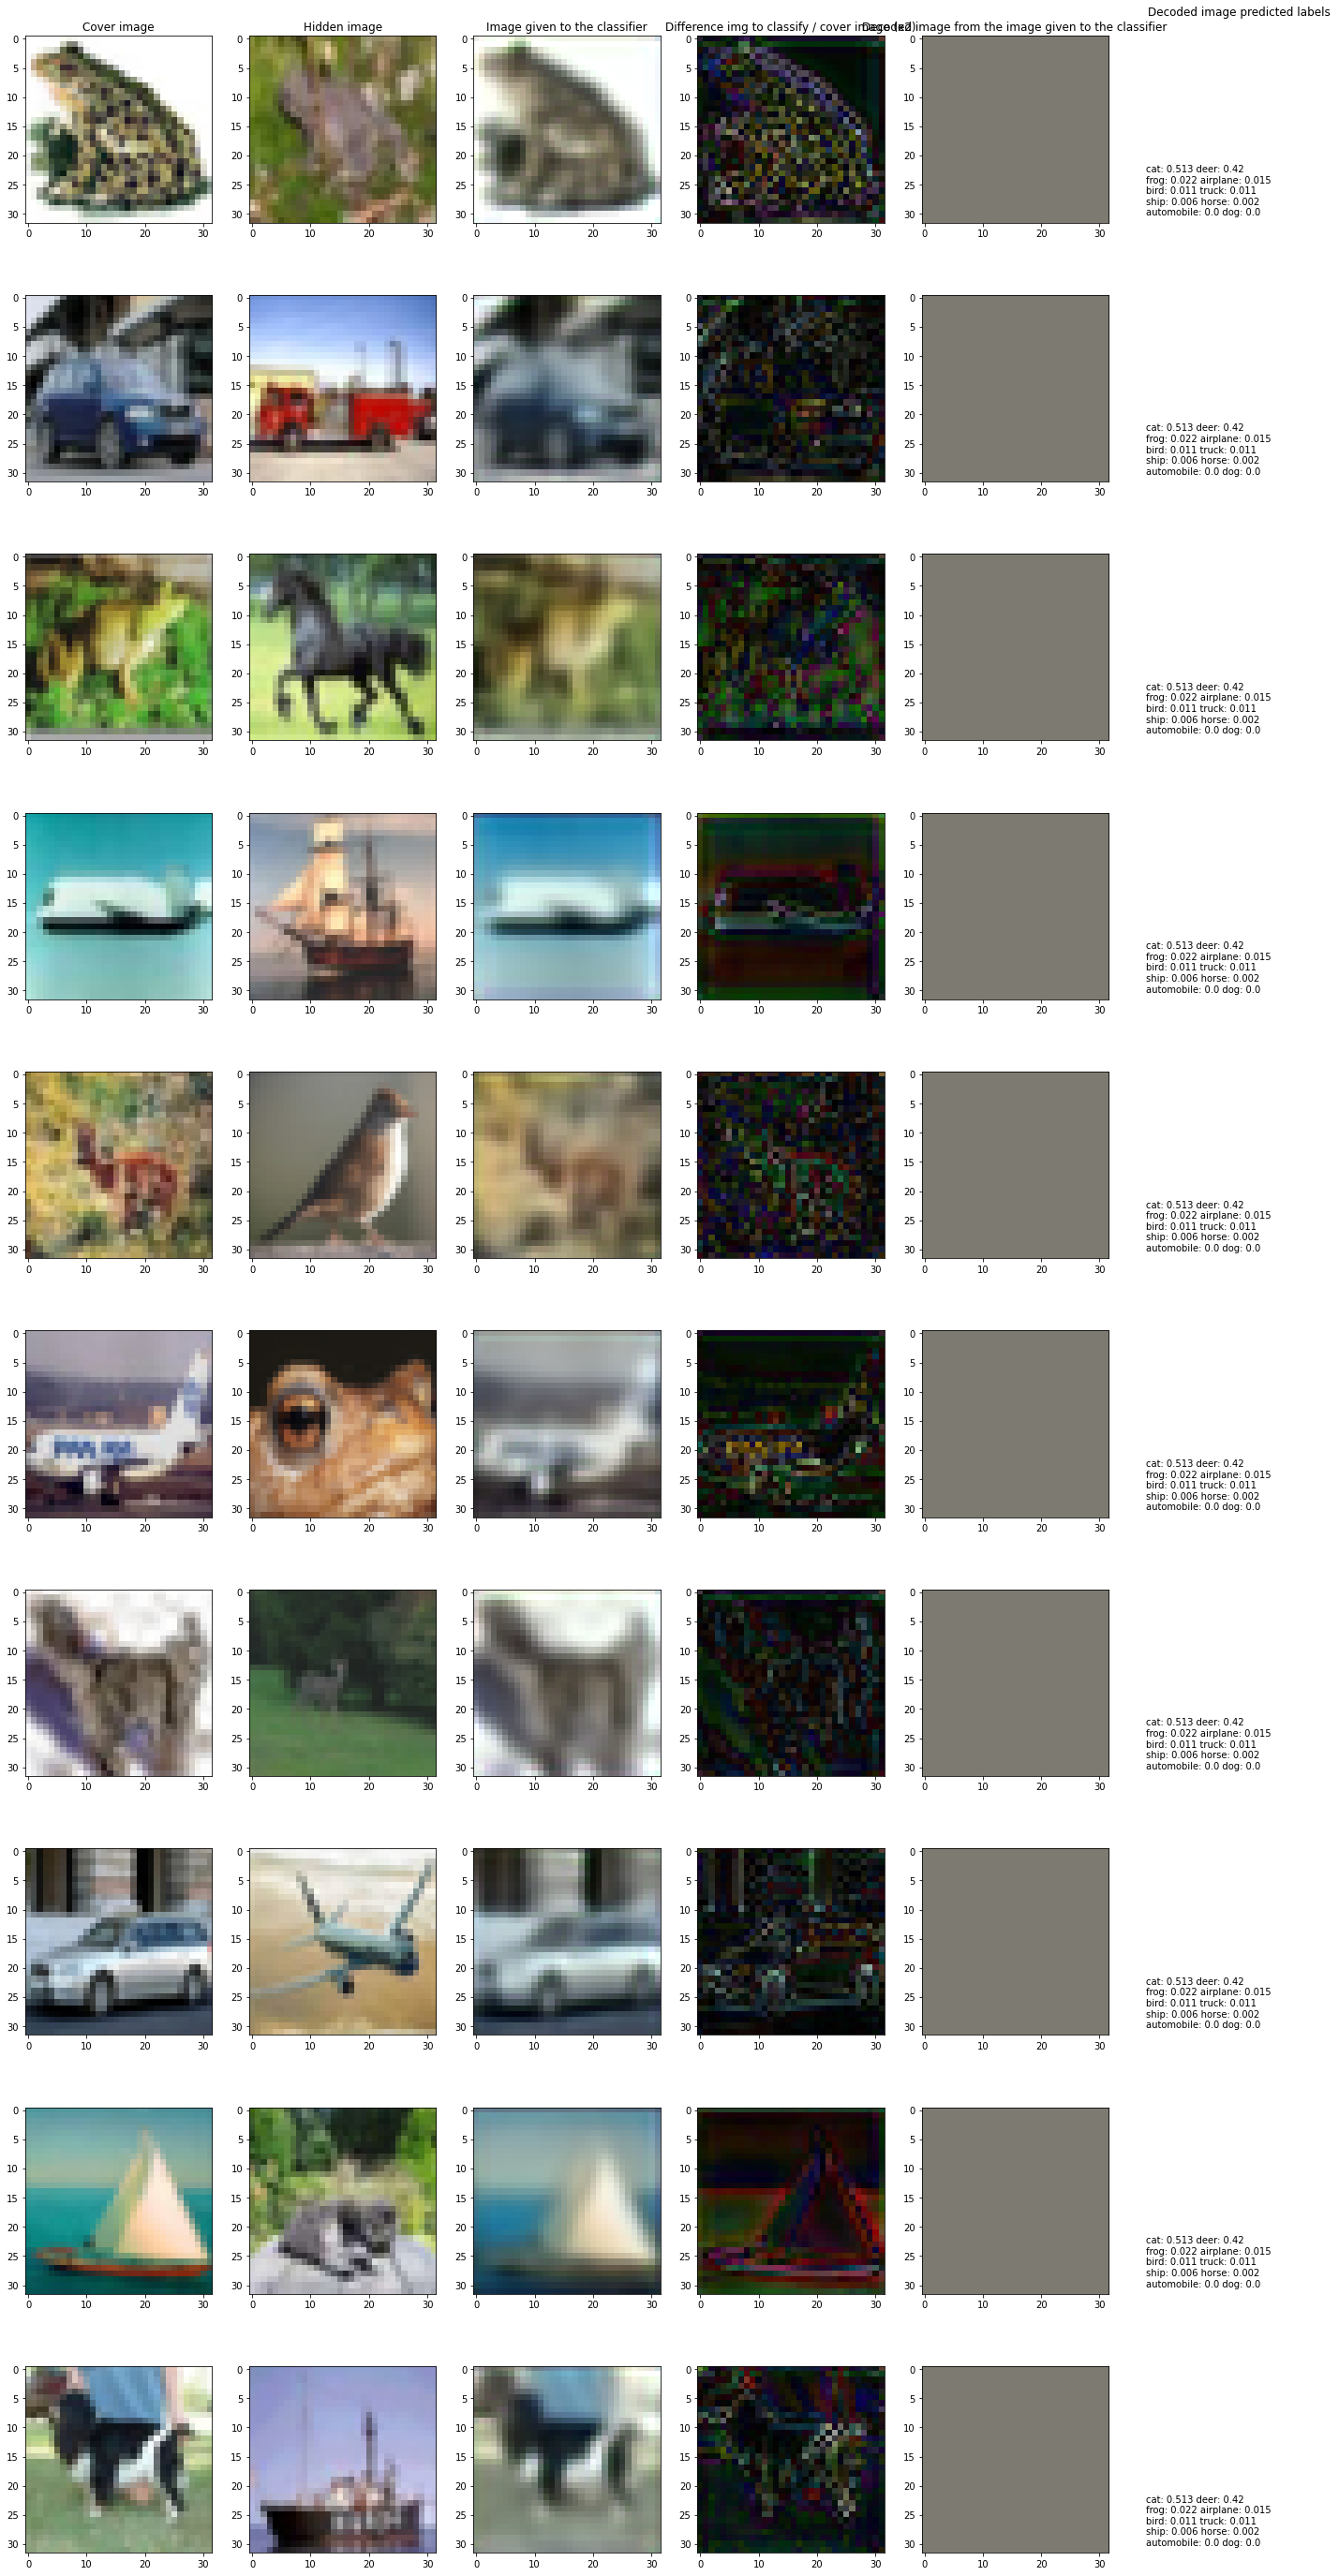

In [ ]:
from numpy.lib.function_base import diff
N=10
d = np.random.randint(0,1000)
img1 = d1[d:d+N]
img2 = d2[d:d+N]
img_to_classif = x_train_after_combi[d:d+N]
diff = np.abs(img_to_classif*255-img1)*2
img_decoded = decoder.predict(x_train_after_combi[d:d+N])

f, axarr = plt.subplots(N,6, figsize=(25,N*5))



y_pred = nrfXT.classifier(img_decoded)
pred_labels = get_cifar_classes(y_pred)


for i in range(N):

  if i == 0:
    axarr[i][0].set_title("Cover image")
    axarr[i][1].set_title("Hidden image")
    axarr[i][2].set_title("Image given to the classifier")
    axarr[i][3].set_title("Difference img to classify / cover image (x2)")
    axarr[i][4].set_title("Decoded image from the image given to the classifier")
    axarr[i][5].set_title("Decoded image predicted labels")

  axarr[i][0].imshow(denorm(img1[i]))
  axarr[i][1].imshow(denorm(img2[i]))
  axarr[i][2].imshow(img_to_classif[i])
  axarr[i][3].imshow(denorm(diff[i]))
  axarr[i][4].imshow(img_decoded[i])
  axarr[i][5].text(0,0,pred_labels[i])
  axarr[i][5].axis("off")


In [ ]:
decoder.save_weights('decoder.hdf5')

In [ ]:
nrfXT.save_weights('nrfX.hdf5')

# Old

In [ ]:
filtered

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [ ]:
len(y_pred)

19

In [ ]:
img1 = img1.numpy()

In [ ]:
(2*(img1[13]-0.5)*nrfXT.epsilon + (1-nrfXT.epsilon)*img_carrier)*std+ mean

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[117.66175 , 128.1191  ,  62.265724],
        [112.16158 , 129.76872 ,  64.933304],
        [115.37147 , 126.5715  ,  65.44556 ],
        ...,
        [133.7711  , 132.17099 ,  64.023895],
        [138.56993 , 140.9701  ,  83.17474 ],
        [151.34464 , 145.75168 , 103.82552 ]],

       [[107.720955, 109.88362 ,  62.519924],
        [140.00676 , 142.0166  ,  90.43336 ],
        [134.18977 , 130.36522 ,  70.57184 ],
        ...,
        [128.96912 , 118.773766,  53.968407],
        [133.47578 , 115.12927 ,  62.098644],
        [149.86638 , 127.08537 ,  73.23149 ]],

       [[110.02039 , 112.6437  ,  76.876366],
        [130.97205 , 129.12964 , 102.57103 ],
        [124.974594, 122.51512 , 102.56682 ],
        ...,
        [107.586525,  88.9115  ,  57.169937],
        [105.072815,  93.71155 ,  61.710587],
        [127.17702 , 108.1193  ,  69.06603 ]],

       ...,

       [[ 50.95067 ,  65.03743 ,  58.299324],
        [ 39.19

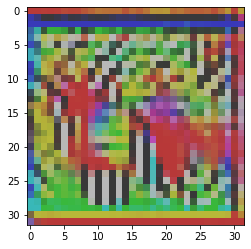

In [ ]:
plt.imshow( ((2*(img1[12]-0.5)*nrfXT.epsilon + (1-nrfXT.epsilon)*img_carrier)*std+ mean)/255  )
plt.imshow( ((2*(img1[2]-0.5)*std+ mean)/255  ))

In [ ]:
nrfXT.classifier(2*(img1-0.5))

<tf.Tensor: shape=(19, 10), dtype=float32, numpy=
array([[4.94296488e-04, 2.78270002e-02, 3.98214326e-07, 7.82141285e-07,
        1.68805059e-07, 1.99647445e-07, 5.51711565e-08, 3.84681189e-05,
        7.68219106e-05, 9.71561849e-01],
       [6.84634209e-01, 3.02964952e-02, 1.38071843e-03, 3.46746645e-04,
        1.56898925e-03, 9.08109767e-04, 2.21348106e-04, 1.15922354e-01,
        1.41094774e-02, 1.50611609e-01],
       [5.31992300e-05, 1.26711966e-05, 1.29321910e-04, 1.70860643e-04,
        9.84108984e-01, 1.62690086e-03, 6.07140129e-04, 1.31895458e-02,
        1.10324490e-05, 9.03710097e-05],
       [4.31821290e-09, 9.99995589e-01, 3.97957085e-14, 2.87002647e-14,
        5.83167141e-14, 1.27294966e-14, 1.46679598e-12, 2.44403651e-12,
        1.11816745e-09, 4.39205633e-06],
       [3.27900088e-05, 9.98322308e-01, 1.02893982e-05, 2.93608955e-05,
        3.06300308e-07, 2.05587858e-04, 2.58104614e-04, 1.78233004e-05,
        1.77106576e-05, 1.10563380e-03],
       [8.47454593e-02, 1

# Normal adversarial attack

In [ ]:
from art import config
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import AutoProjectedGradientDescent
from art.utils import get_file


In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
model_snn = model

In [ ]:
classifier_smallCNN = KerasClassifier(model=model_snn, use_logits=True)

In [ ]:
classifier_natural = KerasClassifier(model=natural_model, use_logits=True, clip_values=[0,1])
classifier_robust = KerasClassifier(model=robust_model, use_logits=True, clip_values=[0,1])

In [ ]:
import time


In [ ]:
32*4


128

In [ ]:
t1 = time.time()

tensor = combi.predict(np.concatenate([ d1[:10000], d2[:10000]], axis=-1) )

t2 = time.time()

In [ ]:
print(t2-t1)

12.974288702011108


In [ ]:

n = 64
num_classes = 10
rand_target = np_utils.to_categorical(np.random.randint(0,9,n),num_classes)

attack = ProjectedGradientDescent(classifier_robust,norm=2, eps=100., eps_step=0.01, max_iter=50, targeted=True) 



t1 = time.time()

X_test_adv = attack.generate(x_test[:n], y=rand_target)

t2 = time.time()
print(t2-t1)

y_adv_pred = classifier_robust.predict(X_test_adv)
accuracy = np.mean(np.argmax(y_adv_pred, axis=1) == np.argmax(y_test[:n], axis=1))

print("Accuracy on first %i adversarial test samples: %f" % (n, accuracy))



PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

60.173022985458374
Accuracy on first 64 adversarial test samples: 0.796875


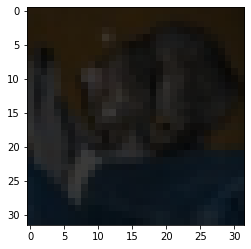

In [ ]:
plt.imshow(X_test_adv[0]/255.)

In [ ]:
np.sqrt(np.sum(np.square(x_test[0]-X_test_adv[0])))

500.00003

In [ ]:
natural_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 171)  4788        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 171)  684        ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 32, 32, 171)  0           ['batch_normalization_1[0][